In [1]:
# !pip install --user -U nltk

In [ ]:
from pathlib import Path
import os
import nltk
import string
import numpy as np
import random
import matplotlib.pyplot as plt

In [ ]:
DATA = Path('/content/drive/My Drive/ML')

In [ ]:
# !tar xzvf "/content/drive/My Drive/ML/email_data.tar.gz"

In [ ]:
!ls enron1

ham  spam  Summary.txt


In [ ]:
!cat enron1/Summary.txt

Legitimate
----------
- Owner: farmer-d
- Total number: 3672 emails
- Date of first email: 1999-12-10
- Date of last email: 2002-01-11
- Similars deletion: No
- Encoding: No


Spam
----
- Owner: GP
- Total number: 1500 emails
- Date of first email: 2003-12-18
- Date of last email: 2005-09-06
- Similars deletion: No
- Encoding: No

Spam:Legitimate rate = 1:3
Total number of emails (legitimate + spam): 5975


In [ ]:
ham_list = os.listdir("enron1/ham/")
spam_list = os.listdir("enron1/spam/")

In [ ]:
with open("enron1/ham/" + ham_list[0], 'r') as f:
    txt = f.readlines()
    print(txt)
    print(''.join(txt))

['Subject: vastar / big thicket\n', 'anita ,\n', 'per our meeting yesterday , i have set up the necessary usage tickets . i\n', 'could not set up just one b / c they can only be set up for approx . 3 months at\n', 'a time . therefore , i had to set up 7 usage tickets which are listed below :\n', '02 / 99 to 04 / 99 sitara deal 396904\n', '05 / 99 to 07 / 99 sitara deal 396925\n', '08 / 99 to 10 / 99 sitara deal 396942\n', '11 / 99 to 12 / 99 sitara deal 396951\n', '01 / 00 to 03 / 00 sitara deal 396956\n', '04 / 00 to 06 / 00 sitara deal 396964\n', '07 / 00 to 09 / 00 sitara deal 396680\n', 'for 9 / 00 i will go back and repath it for the lst through 12 th so it should\n', 'be correct when you allocate it . let me know when you have the track ids for\n', 'the other months . thanks .']
Subject: vastar / big thicket
anita ,
per our meeting yesterday , i have set up the necessary usage tickets . i
could not set up just one b / c they can only be set up for approx . 3 months at
a time . th

In [ ]:
ham = []
for fn in ham_list:
    with open("enron1/ham/" + fn, 'r') as f:
        ham.append(f.readlines())

In [ ]:
spam = []
for fn in spam_list:
    with open("enron1/spam/" + fn, 'rb') as f:
        aux = [str(l, errors="ignore") for l in f.readlines()]
        spam.append(aux)

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

def get_stopwords():
    stopwords = nltk.corpus.stopwords.words("english")
    stopwords.extend(string.punctuation)
    stopwords.append('')
    return set(stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def extract_words(email):
    # break the email string (joined from a list of strings) into words
    words = nltk.word_tokenize(' '.join(email))  
    if words[0].lower() == 'subject':  # no need to keep "subject" word in an email
        words = words[1:]

    # remove numbers
    for i, w in enumerate(words):
        words[i] = ''.join([j for j in w if not j.isdigit()])

    # remove stopwords and words smaller than 2 characters
    stopwords = get_stopwords()
    words = [w.lower() for w in words if w not in stopwords and len(w) > 2]

    # stem the words
    stemmer = nltk.stem.PorterStemmer()
    words = [stemmer.stem(w) for w in words]

    return words

# extract_words(spam[0])

In [ ]:
labels = np.r_[np.zeros(len(ham)), np.ones(len(spam))]  # 0 for ham; 1 for spam
all_emails = [extract_words(x) for x in (ham+spam)]

In [ ]:
all_data = list(zip(all_emails, labels))
random.shuffle(all_data)
all_emails, labels = zip(*all_data)

percent = 0.8  # get this much for training data
threshold = int(len(all_emails)*percent)

train_emails = all_emails[:threshold]
test_emails = all_emails[threshold:]

train_labels = np.array(labels[:threshold], dtype=np.int)
test_labels = np.array(labels[threshold:], dtype=np.int)

In [ ]:
# def all_vocab(emails):
#     """Go through every email and aggregate words in a set to ensure each word appears only once."""
#     vocab = set()  # use set to remove ordering and keep only unique words
#     for m in emails:
#         vocab = vocab.union(extract_words(m))
#     return(vocab)

In [ ]:
# v = all_vocab(ham + spam)
# len(v)

In [ ]:
def compute_word_dist(emails):
    """Return a nltk.FreqDist object with the distribution of words."""

    dist = nltk.FreqDist()
    for m in emails: 
        for w in m:
            dist[w] +=1
    return dist

In [ ]:
ham_dist = compute_word_dist([m for i, m in enumerate(train_emails) if train_labels[i]==0])  # ham
spam_dist = compute_word_dist([m for i, m in enumerate(train_emails) if train_labels[i]==1]) # spam 

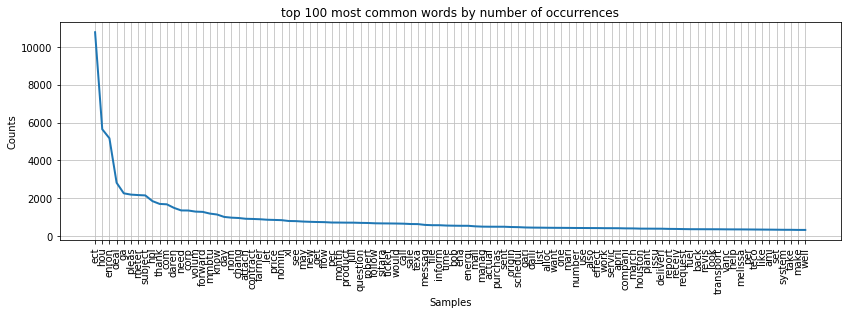

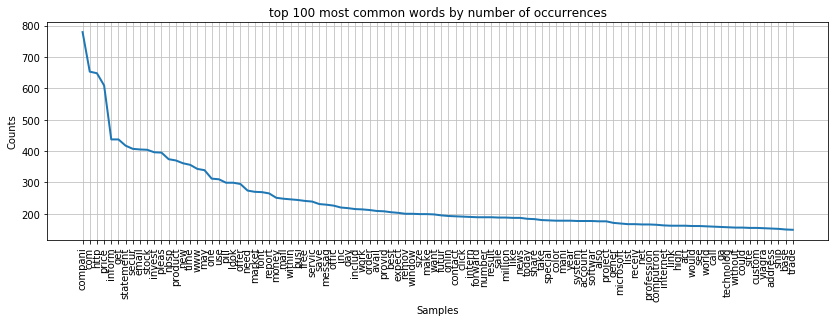

In [ ]:
N = 100
plt.figure(figsize=(14,4))
ham_dist.plot(N, title=f"top {N} most common words by number of occurrences")

plt.figure(figsize=(14,4))
spam_dist.plot(N, title=f"top {N} most common words by number of occurrences")

In [ ]:
N_ham = 100  # length of the dictionary/vocabulary
N_spam = 200
ham_vocab = [w for w, _ in ham_dist.most_common(N_ham)]
spam_vocab = [w for w, _ in spam_dist.most_common(N_spam)]
all_vocab = ham_vocab + spam_vocab

In [ ]:
def bag_of_words(email, vocab):
    """Calculate a bag of words for each email."""

    bow = np.zeros(len(vocab))
    for w in extract_words(email):
        if w in vocab:
            bow[vocab.index(w)] += 1
    return bow

In [ ]:
# hits = [0] * 100
# for i, m in enumerate(ham[:100]):
#     hits[i] = sum(bag_of_words(m, all_vocab))
# any(hits)

# check if the bag of words gets a hit in the dictionary/vocabulary
any(bag_of_words(ham[1], all_vocab))

True